# Spaceship Titanic XGBOOST Model

## Imports

In [1]:
import pandas as pd
from xgboost import XGBClassifier as xgbc
from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

## Part 1: Read the Data

In [2]:
df = pd.read_csv("data/train.csv")

## Part 1-1: View the Data

In [3]:
df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [4]:
df['HomePlanet'].value_counts()

HomePlanet
Earth     4602
Europa    2131
Mars      1759
Name: count, dtype: int64

In [5]:
df['Destination'].value_counts()

Destination
TRAPPIST-1e      5915
55 Cancri e      1800
PSO J318.5-22     796
Name: count, dtype: int64

In [6]:
# Quick summary of missing values and data types
print(df.info())
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB
None
PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             2

## Part 2: Feature Engineering

### Part 2.1: Dropping Irrelevant Features and Engineering New Features

In [7]:
# Drop irrelevant columns
columns_to_drop = ['PassengerId', 'Name']
df.drop(columns_to_drop, axis=1, inplace=True)

# Split the 'Cabin' column into 'Deck', 'CabinNumber', and 'Side'
df['Deck'] = df['Cabin'].str.extract(r'([A-Za-z])')  # Extract the first letter (Deck)
df['CabinNumber'] = df['Cabin'].str.extract(r'(\d+)')  # Extract the digits (Cabin number)
df['Side'] = df['Cabin'].str.extract(r'([PS])')  # Extract the side ('P' for Port, 'S' for Starboard)

# Drop the original 'Cabin' column after the split
df.drop('Cabin', axis=1, inplace=True)

# Combine all the spending features into a single total spend feature
spend_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
df[spend_cols] = df[spend_cols].fillna(0)  # Fill missing spending data with 0
df['TotalSpend'] = df[spend_cols].sum(axis=1)  # Create TotalSpend as the sum of all spending features

# Drop individual spend columns
# df.drop(spend_cols, axis=1, inplace=True)

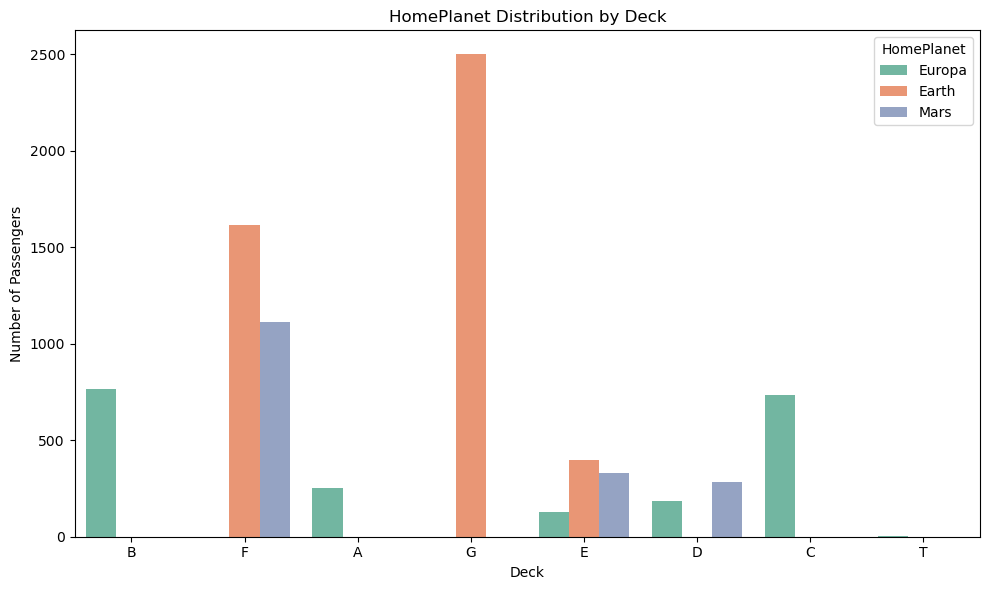

In [8]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Deck', hue='HomePlanet', palette='Set2')
plt.title('HomePlanet Distribution by Deck')
plt.xlabel('Deck')
plt.ylabel('Number of Passengers')
plt.tight_layout()
plt.show()

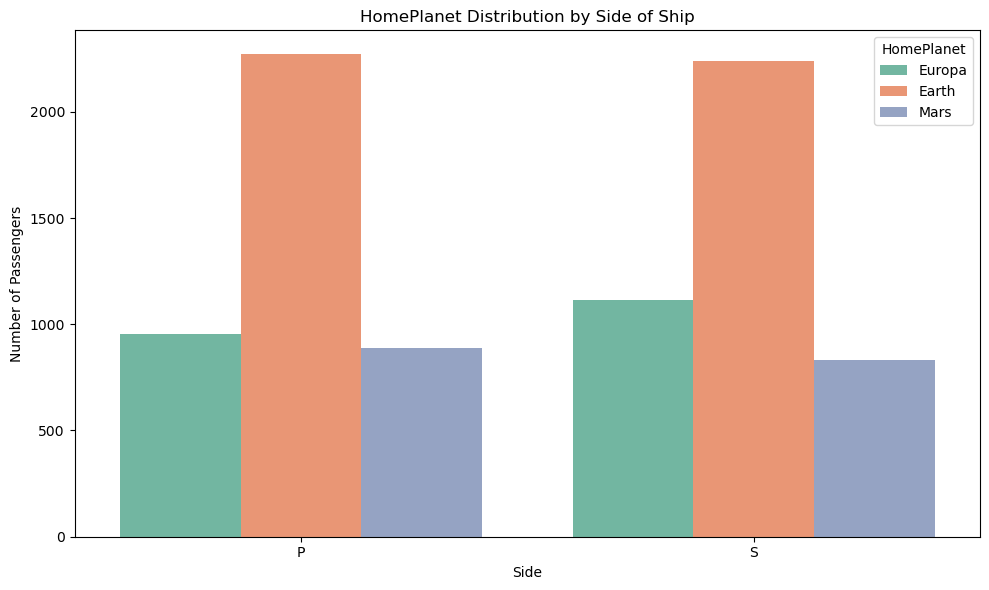

In [9]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Side', hue='HomePlanet', palette='Set2')
plt.title('HomePlanet Distribution by Side of Ship')
plt.xlabel('Side')
plt.ylabel('Number of Passengers')
plt.tight_layout()
plt.show()

C:\Users\Santiago\AppData\Local\Temp\ipykernel_24724\2488636897.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='CryoSleep', y='Spa', palette='Set2')


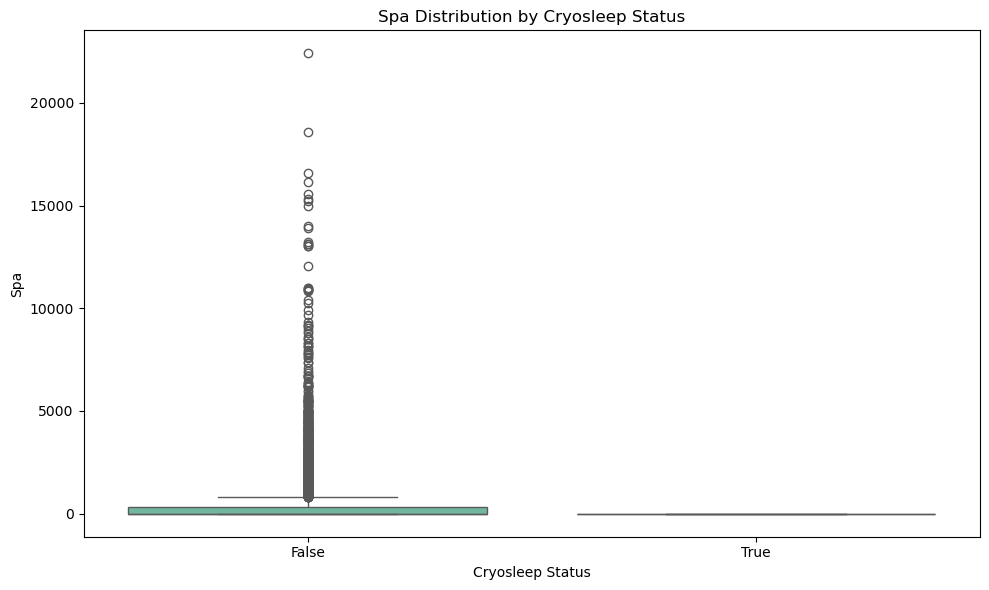

In [10]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='CryoSleep', y='Spa', palette='Set2')
plt.title('Spa Distribution by Cryosleep Status')
plt.xlabel('Cryosleep Status')
plt.ylabel('Spa')
plt.tight_layout()
plt.show()

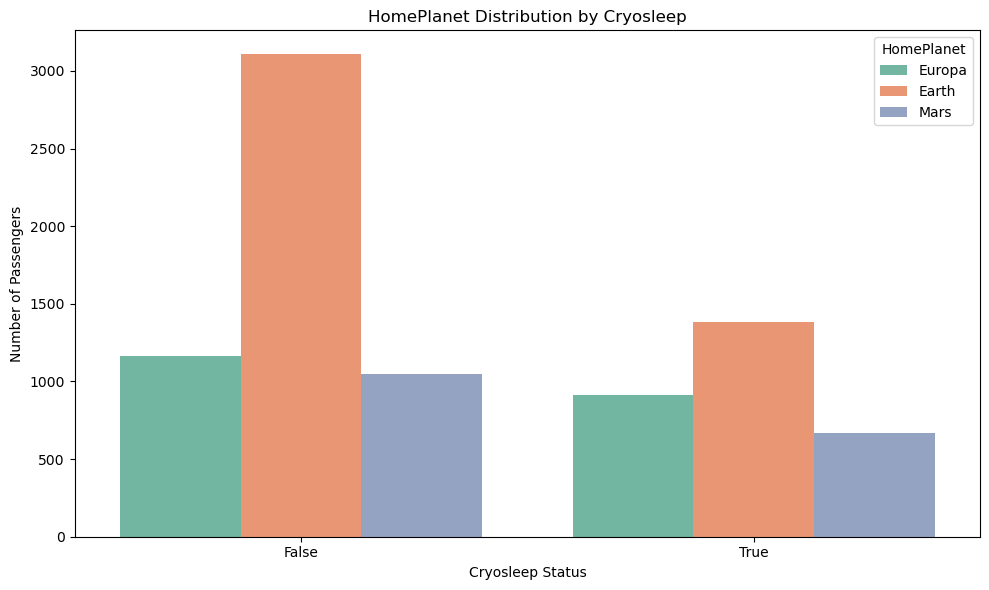

In [11]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='CryoSleep', hue='HomePlanet', palette='Set2')
plt.title('HomePlanet Distribution by Cryosleep')
plt.xlabel('Cryosleep Status')
plt.ylabel('Number of Passengers')
plt.tight_layout()
plt.show()

### Part 2.2: Eliminating missing values

In [12]:
# Fill missing values for each of the extracted features
df['Deck'] = df['Deck'].fillna('None')
df['CabinNumber'] = df['CabinNumber'].fillna('None')
df['Side'] = df['Side'].fillna('None')

# Fill missing boolean values (CryoSleep) with false if spenditure was 0
df['CryoSleep'] = df['CryoSleep'].fillna(df['TotalSpend'] == 0).astype(bool)

# Filter the DataFrame to get the rows where VIP is True
vip_df = df[df['VIP'] == True]

# Calculate the average spending of VIPs
avg_vip_spend = vip_df['TotalSpend'].mean()

# Use this average to set the spending threshold
# Fill missing VIP values based on whether TotalSpend exceeds the average VIP spend
df['VIP'] = df['VIP'].fillna(df['TotalSpend'] > avg_vip_spend)

# Fill missing numerical values for 'Age' with the median
df['Age'] = df['Age'].fillna(df['Age'].median())

# Fill missing categorical values for 'HomePlanet' and 'Destination' with the most common value (mode)
df['HomePlanet'] = df['HomePlanet'].fillna(df['HomePlanet'].mode()[0])
df['Destination'] = df['Destination'].fillna(df['Destination'].mode()[0])

C:\Users\Santiago\AppData\Local\Temp\ipykernel_24724\3015732875.py:7: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['CryoSleep'] = df['CryoSleep'].fillna(df['TotalSpend'] == 0).astype(bool)
C:\Users\Santiago\AppData\Local\Temp\ipykernel_24724\3015732875.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['VIP'] = df['VIP'].fillna(df['TotalSpend'] > avg_vip_spend)


In [13]:
# Check for any remaining missing values
print(df.isnull().sum())

HomePlanet      0
CryoSleep       0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Transported     0
Deck            0
CabinNumber     0
Side            0
TotalSpend      0
dtype: int64


In [14]:
df.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck,CabinNumber,Side,TotalSpend
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,B,0,P,0.0
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,F,0,S,736.0
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,A,0,S,10383.0
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,A,0,S,5176.0
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,F,1,S,1091.0


## Part 3: Encoding our values

In [15]:
# Encode HomePlanet
le_homeplanet = LabelEncoder()
df['HomePlanet'] = le_homeplanet.fit_transform(df['HomePlanet'].astype(str))

# Encode Destination
le_destination = LabelEncoder()
df['Destination'] = le_destination.fit_transform(df['Destination'].astype(str))

# Encode Deck
le_deck = LabelEncoder()
df['Deck'] = le_deck.fit_transform(df['Deck'].astype(str))

# Encode CabinNumber
le_cabinnumber = LabelEncoder()
df['CabinNumber'] = le_cabinnumber.fit_transform(df['CabinNumber'].astype(str))

# Encode Side
le_side = LabelEncoder()
df['Side'] = le_side.fit_transform(df['Side'].astype(str))

# Convert CryoSleep and VIP to int
df['CryoSleep'] = df['CryoSleep'].astype(int)
df['VIP'] = df['VIP'].astype(int)

In [16]:
# Check the result of encoding
df.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck,CabinNumber,Side,TotalSpend
0,1,0,2,39.0,0,0.0,0.0,0.0,0.0,0.0,False,1,0,1,0.0
1,0,0,2,24.0,0,109.0,9.0,25.0,549.0,44.0,True,5,0,2,736.0
2,1,0,2,58.0,1,43.0,3576.0,0.0,6715.0,49.0,False,0,0,2,10383.0
3,1,0,2,33.0,0,0.0,1283.0,371.0,3329.0,193.0,False,0,0,2,5176.0
4,0,0,2,16.0,0,303.0,70.0,151.0,565.0,2.0,True,5,1,2,1091.0


### Part 3.1: Label Distribution

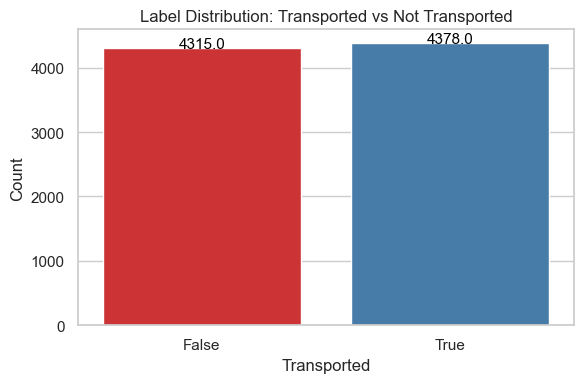

In [17]:
# Set the style
sns.set(style="whitegrid")

# Plot the distribution of the 'Transported' column
plt.figure(figsize=(6, 4))
sns.countplot(x='Transported', hue='Transported', data=df, palette='Set1', legend=False)

# Add labels and title
plt.title('Label Distribution: Transported vs Not Transported')
plt.xlabel('Transported')
plt.ylabel('Count')

# Show values on top of bars
for p in plt.gca().patches:
    plt.gca().annotate(f'{p.get_height()}', 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha='center', va='baseline', fontsize=11, color='black')

plt.tight_layout()
plt.show()

### Part 3.2: Pie Chart version

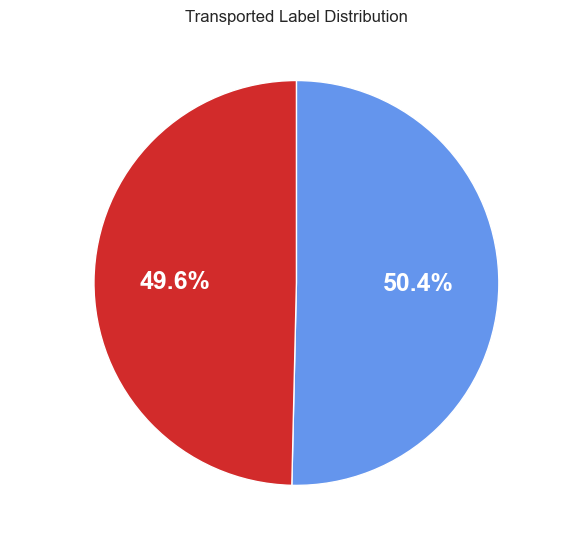

In [18]:
# Count the number of True/False in the 'Transported' column
label_counts = df['Transported'].value_counts()

# Pie chart
plt.figure(figsize=(6, 6))
plt.pie(
    label_counts, 
    labels=label_counts.index.astype(str), 
    autopct='%1.1f%%', 
    colors=['#6495ED', '#D22B2B'], 
    startangle=90, 
    counterclock=False,
    textprops={'color': 'white', 'weight': 'bold', 'fontsize': 18}
)
plt.title('Transported Label Distribution')
plt.tight_layout()
plt.show()

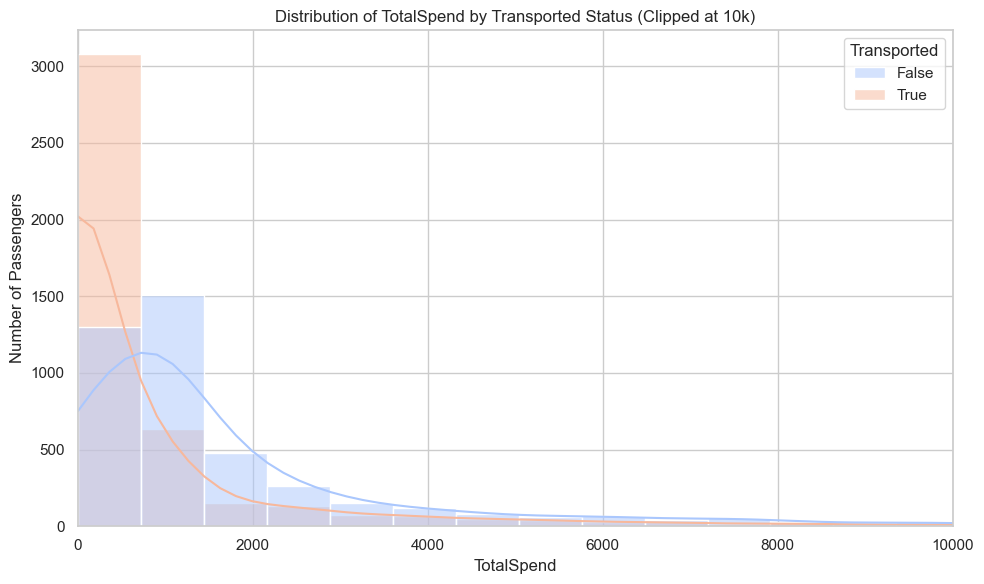

In [19]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='TotalSpend', hue='Transported', bins=50, kde=True, palette='coolwarm')
plt.xlim(0, 10000)  # Focus on the more meaningful range
plt.title('Distribution of TotalSpend by Transported Status (Clipped at 10k)')
plt.xlabel('TotalSpend')
plt.ylabel('Number of Passengers')
plt.tight_layout()
plt.show()


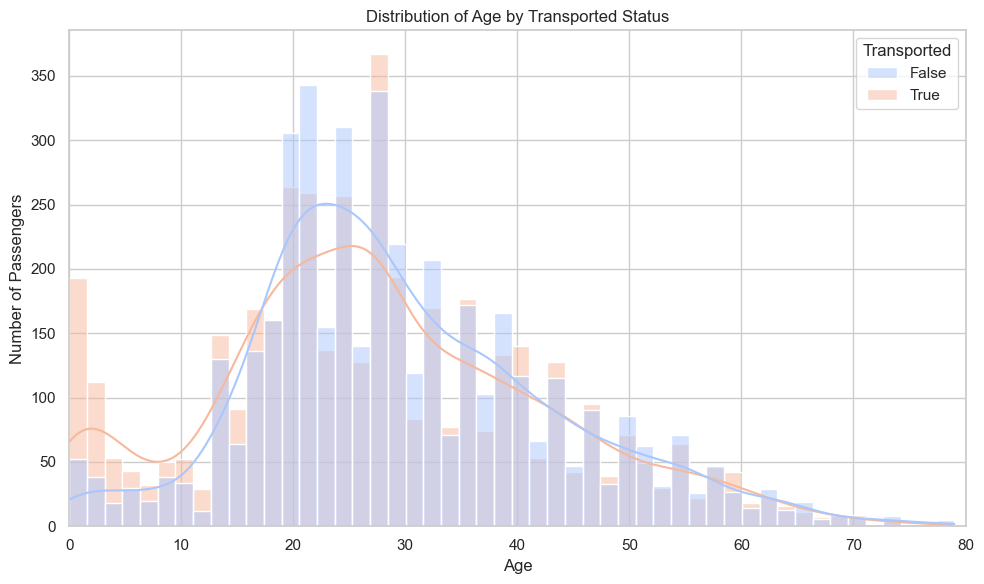

In [20]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='Age', hue='Transported', bins=50, kde=True, palette='coolwarm')
plt.xlim(0, 80)  # Focus on the more meaningful range
plt.title('Distribution of Age by Transported Status')
plt.xlabel('Age')
plt.ylabel('Number of Passengers')
plt.tight_layout()
plt.show()

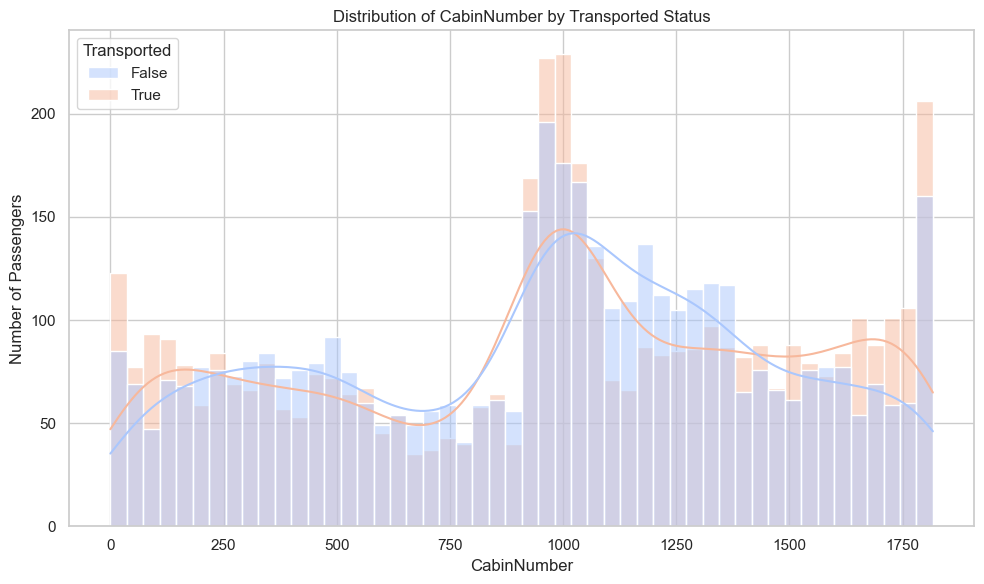

In [21]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='CabinNumber', hue='Transported', bins=50, kde=True, palette='coolwarm')
plt.title('Distribution of CabinNumber by Transported Status')
plt.xlabel('CabinNumber')
plt.ylabel('Number of Passengers')
plt.tight_layout()
plt.show()

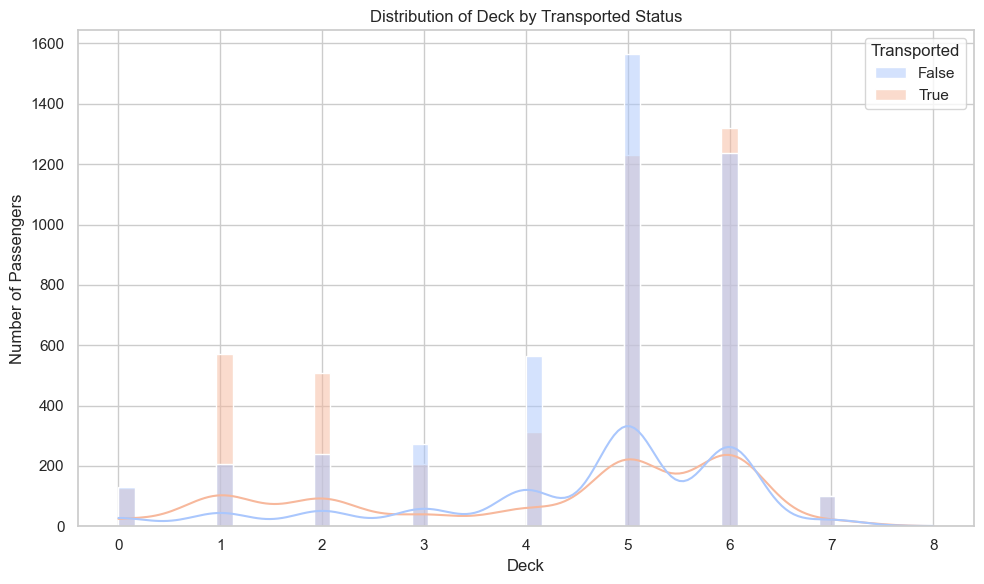

In [22]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='Deck', hue='Transported', bins=50, kde=True, palette='coolwarm')
plt.title('Distribution of Deck by Transported Status')
plt.xlabel('Deck')
plt.ylabel('Number of Passengers')
plt.tight_layout()
plt.show()

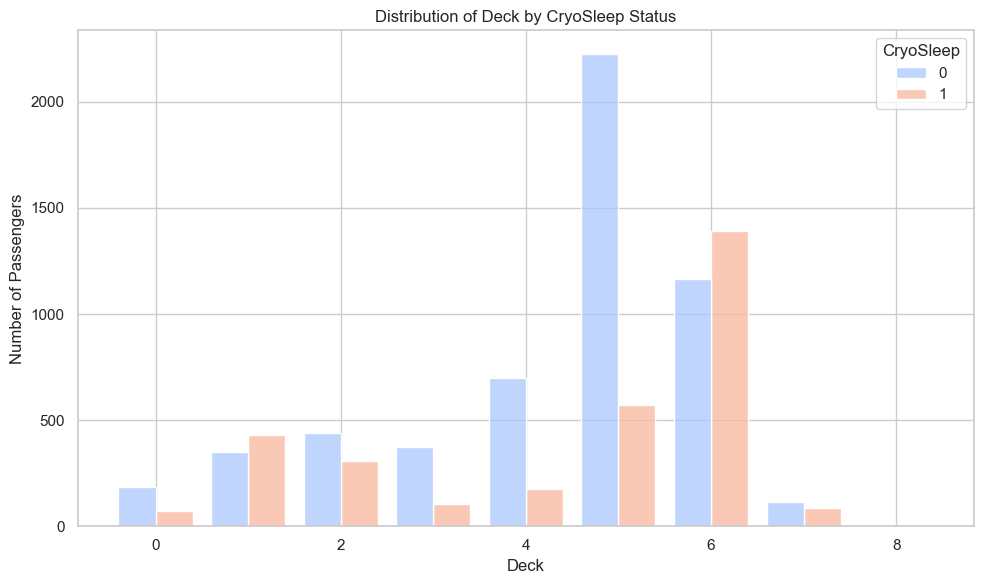

In [23]:
plt.figure(figsize=(10, 6))
sns.histplot(
    data=df,
    x='Deck',
    hue='CryoSleep',
    multiple='dodge',
    shrink=0.8,
    discrete=True,
    palette='coolwarm'
)
plt.title('Distribution of Deck by CryoSleep Status')
plt.xlabel('Deck')
plt.ylabel('Number of Passengers')
plt.tight_layout()
plt.show()


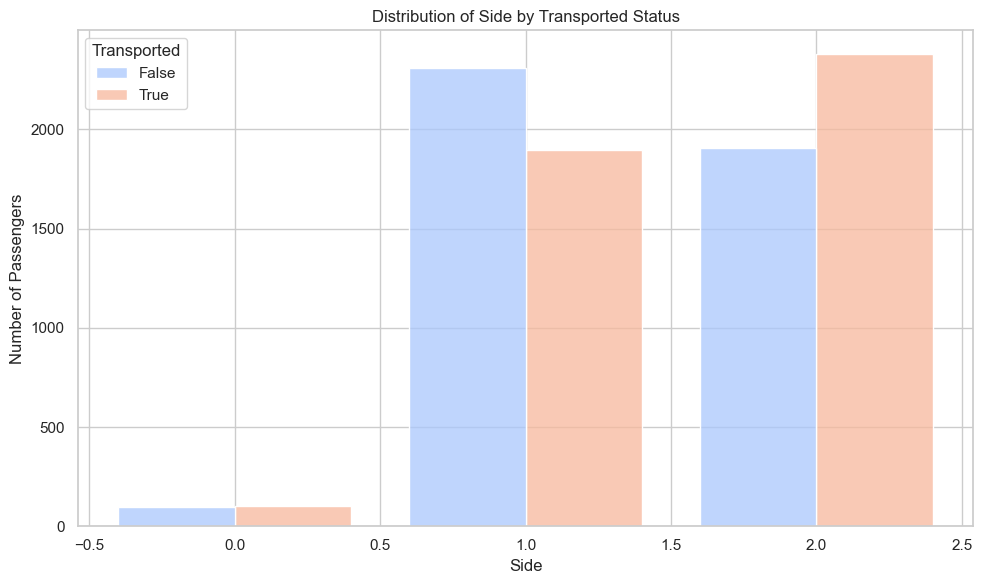

In [24]:
plt.figure(figsize=(10, 6))
sns.histplot(
    data=df,
    x='Side',
    hue='Transported',
    multiple='dodge',
    shrink=0.8,
    discrete=True,
    palette='coolwarm'
)
plt.title('Distribution of Side by Transported Status')
plt.xlabel('Side')
plt.ylabel('Number of Passengers')
plt.tight_layout()
plt.show()

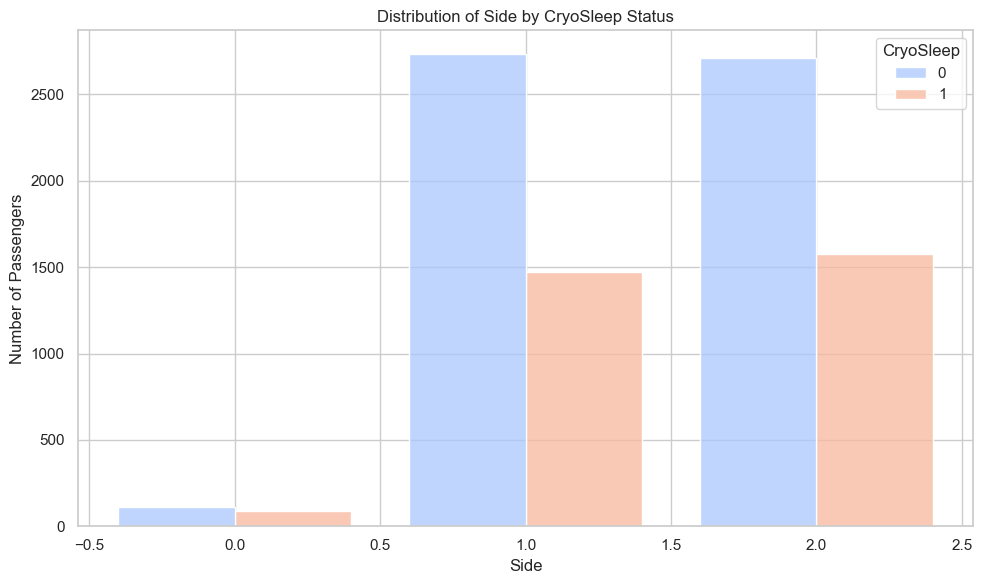

In [25]:
plt.figure(figsize=(10, 6))
sns.histplot(
    data=df,
    x='Side',
    hue='CryoSleep',
    multiple='dodge',
    shrink=0.8,
    discrete=True,
    palette='coolwarm'
)
plt.title('Distribution of Side by CryoSleep Status')
plt.xlabel('Side')
plt.ylabel('Number of Passengers')
plt.tight_layout()
plt.show()


## Part 4: Splitting the dataset

In [26]:
df.drop('TotalSpend', axis=1, inplace=True)
# Define features (X) and target (y)
X = df.drop('Transported', axis=1)  # All columns except 'Transported' are features
y = df['Transported']  # 'Transported' is the target variable

# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = tts(X, y, test_size=0.2, random_state=42)

# Check the shape of the resulting datasets
print(f'Training set size: {X_train.shape}')
print(f'Testing set size: {X_test.shape}')

Training set size: (6954, 13)
Testing set size: (1739, 13)


## Part 5: Train our XGBOOST Model

In [27]:
# Initialize the XGBoost classifier
my_XGBoost = xgbc(n_estimators = 29,random_state=2)

# Train the XGBoost model using the training data
my_XGBoost.fit(X_train, y_train)

# Predict and evaluate
y_pred = my_XGBoost.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.7976


### Make the Predictions and Compute Probability

In [28]:
# Make predictions on the test dataset (class labels: 0 or 1)
xgb_preds = my_XGBoost.predict(X_test)

# Get predicted probabilities for the positive class (malignant cancer)
xgb_probs = my_XGBoost.predict_proba(X_test)[:, 1]

print(f"XGBoost Predictions: {xgb_preds}")
print(f"XGBoost Probabilities: {xgb_probs}")

XGBoost Predictions: [0 1 1 ... 1 1 0]
XGBoost Probabilities: [0.05003861 0.58831984 0.56507576 ... 0.7558121  0.970363   0.07961157]


## Part 6: Evaluate our Model

In [29]:
# Print classification report (precision, recall, F1-score)
report = classification_report(y_test, y_pred, output_dict=True)

# Convert to a DataFrame for pretty display
df_report = pd.DataFrame(report).transpose()
df_report.style.background_gradient(cmap='Blues').format(precision=2)

,precision,recall,f1-score,support
False,0.81,0.78,0.79,861.00
True,0.79,0.82,0.80,878.00
accuracy,0.80,0.80,0.80,0.80
macro avg,0.80,0.80,0.80,1739.00
weighted avg,0.80,0.80,0.80,1739.00


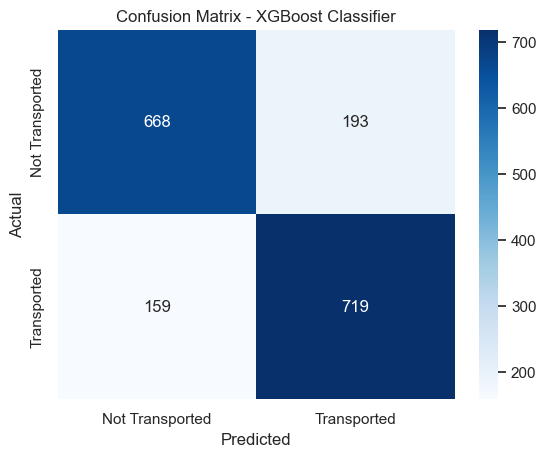

In [30]:
# Print Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Transported', 'Transported'], yticklabels=['Not Transported', 'Transported'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - XGBoost Classifier')
plt.show()

In [31]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, xgb_probs, pos_label=1)

In [32]:
# Calculate the accuracy of the xgb
xgb_accuracy = accuracy_score(y_test, xgb_preds)
# Calculate the Area Under The Curve
xgb_auc = metrics.auc(fpr, tpr)

# Print accuracy and AUC score to evaluate XGBoost's performance
print("XGBoost Accuracy:", xgb_accuracy)
print("XGBoost AUC:", xgb_auc)

XGBoost Accuracy: 0.7975848188614146
XGBoost AUC: 0.8867324639728663


## Part 7: Hyperparameter Tuning via Gridsearch

In [33]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

# Set up the parameter grid
param_grid = {
    'max_depth': [3, 6, 9],
    'learning_rate': [0.1, 0.3, 0.5],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

# Create an XGBoost classifier
xgb_model = XGBClassifier(objective='binary:logistic', eval_metric='logloss')

# Set up GridSearchCV
grid_search = GridSearchCV(xgb_model, param_grid, cv=10, verbose=2, n_jobs=-1)

# Fit the model
grid_search.fit(X_train, y_train)

# Best hyperparameters
print("Best hyperparameters:", grid_search.best_params_)

# Evaluate the best model
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)
print(f"Best Model Accuracy: {roc_auc_score(y_test, y_pred_best):.4f}")

Fitting 10 folds for each of 81 candidates, totalling 810 fits
Best hyperparameters: {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 6, 'subsample': 0.9}
Best Model Accuracy: 0.7968


## Part 8: Plotting Features by Importance

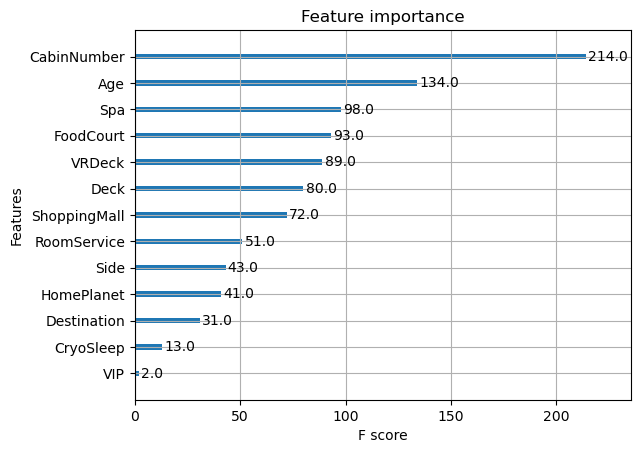

In [50]:
from xgboost import plot_importance

# Plot feature importance
plot_importance(my_XGBoost)
plt.show()

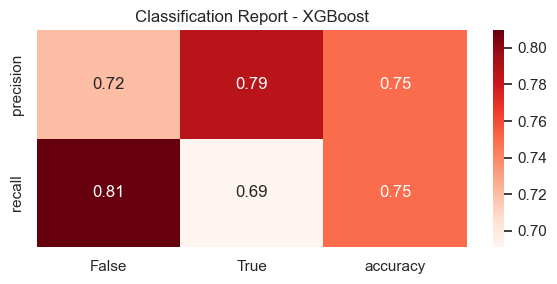

In [34]:
# Get the report as DataFrame
df_report = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).iloc[:2, :3]

plt.figure(figsize=(6, 3))
sns.heatmap(df_report, annot=True, cmap='Reds', fmt=".2f")
plt.title("Classification Report - XGBoost")
plt.tight_layout()
plt.show()